In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# imports

In [9]:
# project path for gcolab
import os
project_path = '/content/drive/My Drive/DataScience/supercoop/supercoapp-data-analysis/'
os.chdir(project_path)

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
sns.set()

import src

In [ ]:
# install pymc3.8 and arviz
!pip install pymc3==3.8
!pip install arviz

     |████████████████████████████████| 911kB 5.2MB/s 
     |████████████████████████████████| 1.6MB 6.3MB/s 
     |████████████████████████████████| 4.7MB 10.0MB/s 
     |████████████████████████████████| 737kB 23.0MB/s 
     |████████████████████████████████| 317kB 46.0MB/s 
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [ ]:
# imports for the sBG model for contractual setting (LTV)
import arviz
import theano
import scipy
import pymc3 as pm
import theano.tensor as tt
from theano.tensor import _shared

In [ ]:
print(arviz.__version__,
      pm.__version__,
      theano.__version__)

# load data

In [4]:
def load_data(folder_path):
  # list all files in folder_path 
  listdir = os.listdir(folder_path)
  print(listdir)

  # read csv and create dataframes
  for csv in listdir:
    if 'orders' in csv:
      df_orders = pd.read_csv(folder_path + csv, 
                              index_col='order_ID',
                              parse_dates=['delivery_date','created_at','updated_at'])
    elif 'members' in csv:
      df_members = pd.read_csv(folder_path + csv, 
                              #index_col=['member_ID', 'order_ID']
                              )
    elif 'products' in csv:
      df_products = pd.read_csv(folder_path + csv, 
                                index_col=['order_ID', 'product_ID']
                                )
  return df_orders, df_members, df_products

In [11]:
# set folder path
folder_path = '/content/drive/My Drive/DataScience/supercoop/supercoapp-data-analysis/data/processed/'
# load data
df_orders, df_members, df_products = src.load_data(folder_path)

['20210417_scoop_members.csv', '20210417_scoop_products.csv', '20210417_scoop_orders.csv', '20210531_scoop_rfm_table.csv', '20210518_scoop_rfm_table.csv']
reminder: data from scoop company account (#46) is included


In [ ]:
# check if dates have been parsed
df_orders.dtypes

supplier_ID                           int64
delivery_date                datetime64[ns]
created_at                   datetime64[ns]
updated_at                   datetime64[ns]
open_order                             bool
scoop_margin                        float64
supplier_margin                     float64
total_order_value                   float64
num_participating_members           float64
dtype: object

In [ ]:
df_products.head(2)

name  ... net_total_price
order_ID product_ID                                                ...                
1        3                  Artischockenherzen geviertelt in Lake  ...           17.94
         4           Tomaten getrocknet in Olivenöl, extra saftig  ...           25.92

[2 rows x 13 columns]

# Retention cohorts
[4 customer retention metrics](https://www.appcues.com/blog/customer-retention-metrics)

- avg. order value for each user
- total order value for each user


https://towardsdatascience.com/a-step-by-step-introduction-to-cohort-analysis-in-python-a2cbbd8460ea


In [12]:
from operator import attrgetter
def cohort_analysis(df_members):
    '''
    takes in:
        df_members dataframe
    returns:
        a retention matrix and cohort pivot table
    example:
        retention_matrix, cohort_pivot = cohort_analysis(df_members)

    References:
    - https://towardsdatascience.com/a-step-by-step-introduction-to-cohort-analysis-in-python-a2cbbd8460ea
    '''
    # calculate quarter when delivery took place
    df_members['delivery_quarter'] = df_members['delivery_date'].dt.to_period('Q')
    print('delivery_quarter: \n', df_members['delivery_quarter'])
    # add cohort column (first_seen)
    df_members['cohort'] = df_members.groupby('member_ID')['delivery_date'] \
                                            .transform('min').dt.to_period('Q')
    df_members.reset_index(inplace=True, drop=True)

    # aggregate chort
    members_cohort = df_members.groupby(['cohort', 'delivery_quarter']) \
                            .agg(n_members=('member_ID', 'nunique')) \
                            .reset_index(drop=False)

    members_cohort['period_number'] = (members_cohort.delivery_quarter
                                       - members_cohort.cohort).apply(attrgetter('n'))

    # pivot table
    cohort_pivot = members_cohort.pivot_table(index='cohort',
                                              columns='period_number',
                                              values='n_members')
    print('cohort pivot: ', cohort_pivot)

    # retention matrix
    cohort_size = cohort_pivot.iloc[:, 0]
    retention_matrix = cohort_pivot.div(cohort_size, axis=0)

    print('retention_matrix: ', retention_matrix)

    return retention_matrix, cohort_pivot

In [170]:
df_members

,index,member_ID,order_ID,name,collected?,order_requests,deposits,delivery_date,order_request_value,delivery_quarter,cohort
0,0,1,1,XXX,True,"{'3': {'filled': '1.0', 'ordered': '1.0'}, '25...",NaN,2019-12-13,89.49,2019Q4,2019Q4
1,1,2,1,XXX,True,"{'39': {'filled': '1.0', 'ordered': '1.0'}, '6...",NaN,2019-12-13,16.22,2019Q4,2019Q4
2,2,3,1,XXX,True,"{'3': {'filled': '0.0', 'ordered': '2.0'}, '7'...",NaN,2019-12-13,20.28,2019Q4,2019Q4
3,3,4,1,XXX,True,"{'27': {'filled': '1.0', 'ordered': '1.0'}, '4...",NaN,2019-12-13,11.96,2019Q4,2019Q4
4,4,7,1,XXX,True,"{'27': {'filled': '1.0', 'ordered': '1.0'}, '1...",NaN,2019-12-13,17.32,2019Q4,2019Q4
...,...,...,...,...,...,...,...,...,...,...,...
3814,3814,58,320,XXX,True,{'new_product_7': {'filled': '2'}},NaN,2021-03-19,1.20,2021Q1,2020Q4
3815,3815,74,320,XXX,True,{'new_product_18': {'filled': '1'}},NaN,2021-03-19,1.98,2021Q1,2021Q1
3816,3816,77,320,XXX,True,{'new_product_4': {'filled': '1'}},NaN,2021-03-19,5.42,2021Q1,2021Q1
3817,3817,78,320,XXX,True,{'new_product_7': {'filled': '2'}},NaN,2021-03-19,1.20,2021Q1,2021Q1


In [14]:
# main function
retention_matrix, cohort_pivot = cohort_analysis(df_members)

delivery_quarter: 
 0       2019Q4
1       2019Q4
2       2019Q4
3       2019Q4
4       2019Q4
         ...  
3814    2021Q1
3815    2021Q1
3816    2021Q1
3817    2021Q1
3818    2021Q1
Name: delivery_quarter, Length: 3819, dtype: period[Q-DEC]
cohort pivot:  period_number     0     1     2     3     4     5
cohort                                           
2019Q4         20.0  15.0  15.0  15.0  15.0  13.0
2020Q1         15.0  14.0   9.0   9.0   9.0   NaN
2020Q2          3.0   2.0   2.0   1.0   NaN   NaN
2020Q3          4.0   4.0   1.0   NaN   NaN   NaN
2020Q4         14.0  12.0   NaN   NaN   NaN   NaN
2021Q1          8.0   NaN   NaN   NaN   NaN   NaN
retention_matrix:  period_number    0         1         2         3     4     5
cohort                                                      
2019Q4         1.0  0.750000  0.750000  0.750000  0.75  0.65
2020Q1         1.0  0.933333  0.600000  0.600000  0.60   NaN
2020Q2         1.0  0.666667  0.666667  0.333333   NaN   NaN
2020Q3         1.

In [174]:
n = sum(cohort_pivot.iloc[:, 0])
t_min, t_max = pd.Period(df_members.delivery_date.min(), 'M'), pd.Period(df_members.delivery_date.max(), 'M')
n, t_min, t_max

(64.0, Period('2019-12', 'M'), Period('2021-03', 'M'))

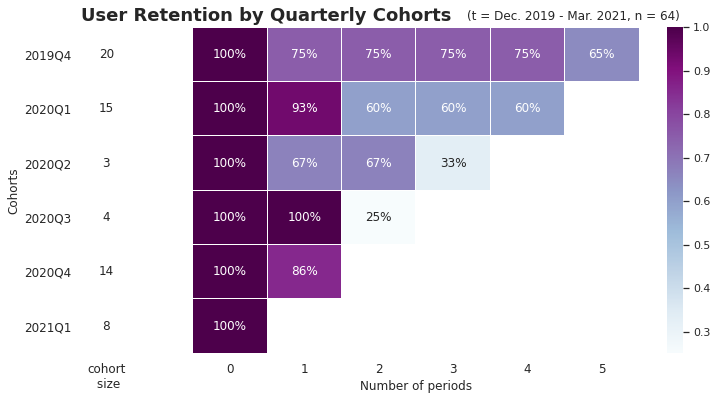

In [221]:
def plot_retention_matrix(retention_matrix, cohort_pivot, export_plot=False):
    cohort_size = cohort_pivot.iloc[:, 0]

    cmap = plt.cm.get_cmap('BuPu')
    fontsizes = {'t1': 18, 'labels': 12, 'annot': 12}

    n = sum(cohort_pivot.iloc[:, 0])
    t_min, t_max = pd.Period(df_members.delivery_date.min(), 'M'), pd.Period(df_members.delivery_date.max(), 'M')

    with sns.axes_style("white"):
        fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

        # cohort size
        cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort\n size'})
        white_cmap = mcolors.ListedColormap(['white'])
        sns.heatmap(cohort_size_df,
                    annot=True, # write data values in each cell
                    cbar=False,
                    fmt='g',
                    cmap=white_cmap,
                    ax=ax[0])
        ax[0].set_title('User Retention by Quarterly Cohorts', fontsize=fontsizes['t1'], fontweight='bold', loc='left')
        ax[0].set(ylabel='Cohorts')
        ax[0].tick_params(labelsize=fontsizes['labels'], labelrotation=0)
        ax[1].annotate("(t = {0} - {1}, n = {2:.0f})".format(*[t_min.strftime('%b. %Y'), t_max.strftime('%b. %Y'), n]),
                 xy=(0.615, 1.0215), xycoords='axes fraction') 
        
        # retention matrix
        sns.heatmap(retention_matrix,
                    mask=retention_matrix.isnull(),
                    annot=True,
                    cbar=True,
                    linewidths=0.005,
                    fmt='.0%',
                    cmap=cmap,
                    ax=ax[1])
        ax[1].set(xlabel='Number of periods', ylabel='')
        ax[1].tick_params(labelsize=fontsizes['labels'])

        #fig.tight_layout()
        if export_plot:
          fig.savefig('matrix_plot_colab.png', dpi=300, bbox_inches='tight')

plot_retention_matrix(retention_matrix, cohort_pivot)

In [222]:
retention_matrix


period_number,0,1,2,3,4,5
cohort,,,,,,
2019Q4,1.0,0.750000,0.750000,0.750000,0.75,0.65
2020Q1,1.0,0.933333,0.600000,0.600000,0.60,NaN
2020Q2,1.0,0.666667,0.666667,0.333333,NaN,NaN
2020Q3,1.0,1.000000,0.250000,NaN,NaN,NaN
2020Q4,1.0,0.857143,NaN,NaN,NaN,NaN
2021Q1,1.0,NaN,NaN,NaN,NaN,NaN


Help on AxesSubplot in module matplotlib.axes._subplots object:

class AxesSubplot(SubplotBase, matplotlib.axes._axes.Axes)
 |  AxesSubplot(fig, *args, **kwargs)
 |  
 |  Base class for subplots, which are :class:`Axes` instances with
 |  additional methods to facilitate generating and manipulating a set
 |  of :class:`Axes` within a figure.
 |  
 |  Method resolution order:
 |      AxesSubplot
 |      SubplotBase
 |      matplotlib.axes._axes.Axes
 |      matplotlib.axes._base._AxesBase
 |      matplotlib.artist.Artist
 |      builtins.object
 |  
 |  Methods inherited from SubplotBase:
 |  
 |  __init__(self, fig, *args, **kwargs)
 |      Parameters
 |      ----------
 |      fig : `matplotlib.figure.Figure`
 |      
 |      *args : tuple (*nrows*, *ncols*, *index*) or int
 |          The array of subplots in the figure has dimensions ``(nrows,
 |          ncols)``, and *index* is the index of the subplot being created.
 |          *index* starts at 1 in the upper left corner and inc

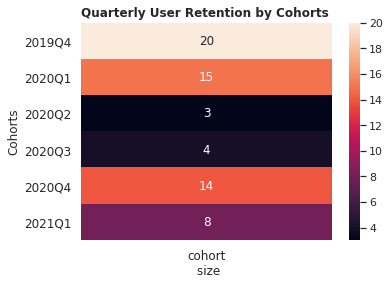

In [139]:
cohort_size = cohort_pivot.iloc[:, 0]
cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort\n size'})

hm = sns.heatmap(cohort_size_df,
            annot=True, # write data values in each cell
            cbar=True,
            cbar_kws={'fraction': 0.2, "use_gridspec" : True},
            fmt='g')
hm.set_title('Quarterly User Retention by Cohorts', fontweight='bold', loc='left')
hm.set(xlabel='', ylabel='Cohorts')
hm.tick_params(labelsize=12, labelrotation=0)

help(hm.axes)


In [88]:
ax

In [ ]:
import os
print( os.getcwd() )
print( os.listdir() )

/content/drive/My Drive/DataScience/supercoop/supercoapp-data-analysis
['notebooks', '.git', 'clean_up_order_table.rb', 'data', 'src', 'models', 'build_image.sh', '.ipython', 'Dockerfile', 'run_ipython.sh', '.config', '.gitignore', 'run_container_testing.sh', 'run_container.sh', '.dockerignore', '.bash_history', 'requirements.txt', 'README.md', 'clv-writeup.ipynb', 'matrix_plot_colab.png']


# CLV - Customer Lifetime Value

https://towardsdatascience.com/calculating-customer-lifetime-values-using-a-shifted-beta-geometric-model-86bf538444f4

### naiv survival rate prediction

In [ ]:
# calculating naiv mean survival rate
mean_survival_rate = np.mean(retention_matrix.sum() / [5, 4, 3, 2, 1])
mean_survival_rate

0.7869444444444443

In [ ]:
# naiv survival prediction for 10 periods
naiv_survival_pred = [mean_survival_rate**i for i in range(0, 7)]
naiv_survival_pred = pd.Series(naiv_survival_pred, 
                               name='naiv survival prediction')
naiv_survival_pred

0    1.000000
1    0.786944
2    0.619282
3    0.487340
4    0.383510
5    0.301801
6    0.237500
Name: naiv survival prediction, dtype: float64

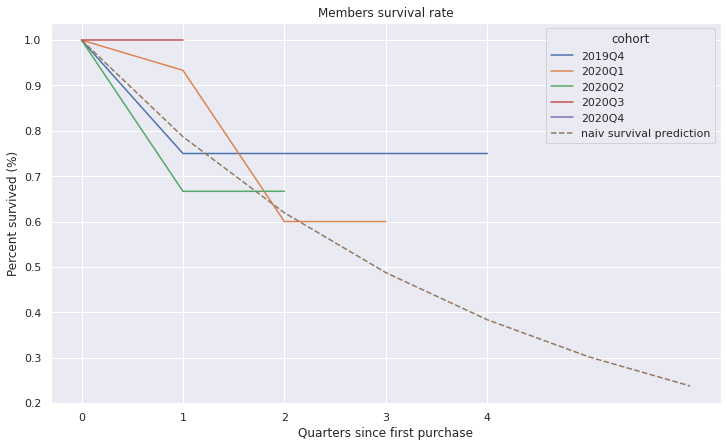

In [ ]:
# plotting retention rate
ax = retention_matrix.T.plot(kind='line',
                             xticks=range(0, 5, 1),
                             figsize=(12, 7),
                             title='Members survival rate')
ax.set_xlabel("Quarters since first purchase")
ax.set_ylabel("Percent survived (%)")

# adding naiv survival prediction line
naiv_survival_pred.plot(ax=ax,
                        legend=True, # adding series name to legend
                        ls='--') # ls -> linestyle


## Shifted Beta Geometric Distribution (sGB) - test
https://discourse.pymc.io/t/shifted-beta-geometric-sbg-distribution-in-pymc3/490/5

In [ ]:
# here is an example of active customer per periode
multi_cohort_data = [[10000, 8000, 6480, 5307, 4391],
                     [10000, 8000, 6480, 5307],
                     [10000, 8000, 6480],
                     [10000, 8000]]

multi_cohort_data 

[[10000, 8000, 6480, 5307, 4391],
 [10000, 8000, 6480, 5307],
 [10000, 8000, 6480],
 [10000, 8000]]

In [ ]:
num_periods = max(list(map(len, multi_cohort_data))) # num_periods = 5

def n_lost(data):
    '''
    calc number of lost entities for each cohort
    '''
    lost = [None]
    for i in range(1, len(data)):
        lost.append(data[i - 1] - data[i])
    return lost

multi_cohort_data_lost = list(map(n_lost, multi_cohort_data)) # finds lost for ech cohort
active_flatten = [i[-1] for i in multi_cohort_data]
active_index = [len(i)-2 for i in multi_cohort_data]
lost_flatten = [j for i in multi_cohort_data_lost for j in i[1:]]
lost_index = [j for i in multi_cohort_data_lost for j in np.arange(len(i[1:]))]

# 2*N data with active customer and churned customer
multi_cohort_data_lost, active_flatten, active_index, lost_flatten, lost_index

([[None, 2000, 1520, 1173, 916],
  [None, 2000, 1520, 1173],
  [None, 2000, 1520],
  [None, 2000]],
 [4391, 5307, 6480, 8000],
 [3, 2, 1, 0],
 [2000, 1520, 1173, 916, 2000, 1520, 1173, 2000, 1520, 2000],
 [0, 1, 2, 3, 0, 1, 2, 0, 1, 0])

In [ ]:
with pm.Model() as model:
    alpha = pm.Uniform('alpha', 0.00001, 1000.0, testval=1)
    beta = pm.Uniform('beta', 0.00001, 1000.0, testval=1)
    p1 = alpha / (alpha + beta) # probability of alpha
    s1 = 1. - p1 # survival?

    def scan_body(t, pt, st):
        pt_1 = ((beta + t - 2) / (alpha + beta + t - 1)) * pt
        st_1 = st - pt_1
        return pt_1, st_1

    (pt, st), _ = theano.scan(scan_body,
                              sequences=np.arange(2, num_periods),
                              outputs_info=[p1, s1])
    pt = tt.concatenate([p1[..., None], pt])
    st = tt.concatenate([s1[..., None], st])
    
    # compute the logp
    # Those who've churned along the way...
    died = tt.log(pt[lost_index]) * lost_flatten

    # and those still active in last period
    still_active = tt.log(st[active_index]) * active_flatten
    retention = pm.Potential('retention', tt.sum(died) + tt.sum(still_active))
    
    trace = pm.sample(cores=4, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 4 chains, 0 divergences:  85%|████████▌ | 3410/4000 [00:32<00:05, 105.80draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [ ]:
pm.find_MAP(model=model)

logp = -40,272, ||grad|| = 19.256: 100%|██████████| 17/17 [00:00<00:00, 833.71it/s]  


{'alpha': array(3.79811334),
 'alpha_interval__': array(-5.56944811),
 'beta': array(15.19185625),
 'beta_interval__': array(-4.17168799)}

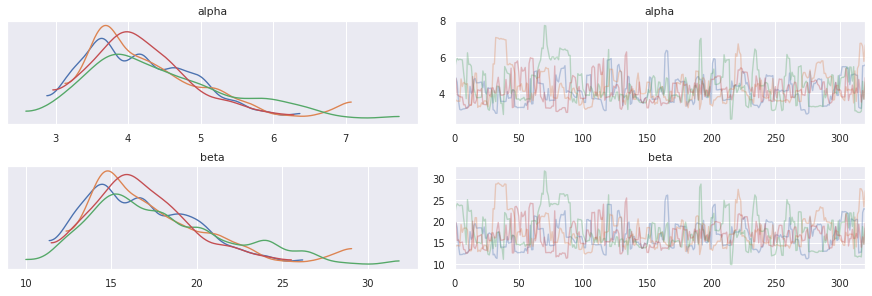

In [ ]:
# posterior analysis / former pm.traceplot(trace)
with model:
    arviz.plot_trace(trace);

In [ ]:
pm.summary(trace)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,4.281,0.825,3.042,5.884,0.062,0.045,179.0,166.0,205.0,158.0,1.02
beta,17.215,3.465,12.119,24.072,0.259,0.191,179.0,165.0,205.0,149.0,1.02


In [ ]:
with model:
    display(arviz.summary(trace, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,4.28,0.83,3.04,5.88,0.06,0.05,178.92,165.95,204.69,158.10,1.02
beta,17.21,3.46,12.12,24.07,0.26,0.19,179.02,165.37,205.12,148.63,1.02


## Shifted Beta Geometric Distribution (sGB) - application
https://discourse.pymc.io/t/shifted-beta-geometric-sbg-distribution-in-pymc3/490/5

In [ ]:
# tolist()
multi_cohort_data = cohort_pivot.values.tolist()

# dropna's
multi_cohort_data = [li for li in multi_cohort_data]

multi_cohort_data

[[20.0, 15.0, 15.0, 15.0, 15.0],
 [15.0, 14.0, 9.0, 9.0, nan],
 [3.0, 2.0, 2.0, nan, nan],
 [4.0, 4.0, nan, nan, nan],
 [5.0, nan, nan, nan, nan]]

In [ ]:
# here is an example of active customer per periode
multi_cohort_data = [[20.0, 15.0, 15.0, 15.0, 15.0],
                     [15.0, 14.0, 9.0, 9.0],
                     [3.0, 2.0, 2.0], 
                     [4.0, 4.0]]

multi_cohort_data 

[[20.0, 15.0, 15.0, 15.0, 15.0],
 [15.0, 14.0, 9.0, 9.0],
 [3.0, 2.0, 2.0],
 [4.0, 4.0]]

In [ ]:
np.arange(5)

array([0, 1, 2, 3, 4])

In [ ]:
num_periods = max(list(map(len, multi_cohort_data)))

def n_lost(data):
    lost = [None]
    for i in range(1, len(data)):
        lost.append(data[i - 1] - data[i])
    return lost

multi_cohort_data_lost = list(map(n_lost, multi_cohort_data))
active_flatten = [i[-1] for i in multi_cohort_data]
active_index = [len(i)-2 for i in multi_cohort_data]
lost_flatten = [j for i in multi_cohort_data_lost for j in i[1:]]
lost_index = [j for i in multi_cohort_data_lost for j in np.arange(len(i[1:]))]

# 2*N data with active customer and churned customer
active_flatten, active_index, lost_flatten, lost_index

([15.0, 9.0, 2.0, 4.0],
 [3, 2, 1, 0],
 [5.0, 0.0, 0.0, 0.0, 1.0, 5.0, 0.0, 1.0, 0.0, 0.0],
 [0, 1, 2, 3, 0, 1, 2, 0, 1, 0])

In [ ]:
multi_cohort_data_lost

[[None, 5.0, 0.0, 0.0, 0.0],
 [None, 1.0, 5.0, 0.0],
 [None, 1.0, 0.0],
 [None, 0.0]]

In [ ]:
num_periods

5

In [ ]:
with pm.Model() as scoop_model:
    # prior distribution
    alpha = pm.Uniform('alpha', 0.00001, 1000.0, testval=1)
    beta = pm.Uniform('beta', 0.00001, 1000.0, testval=1)
    p1 = alpha / (alpha + beta)
    s1 = 1. - p1

    def scan_body(t, pt, st):
        pt_1 = ((beta + t - 2) / (alpha + beta + t - 1)) * pt
        st_1 = st - pt_1
        return pt_1, st_1

    # https://riptutorial.com/theano/example/25038/basic-scan-usage
    (pt, st), _ = theano.scan(scan_body,
                              sequences=np.arange(2, num_periods),
                              outputs_info=[p1, s1])
    pt = tt.concatenate([p1[..., None], pt])
    st = tt.concatenate([s1[..., None], st])
    
    # compute the logp
    # Those who've churned along the way...
    died = tt.log(pt[lost_index]) * lost_flatten

    # and those still active in last period
    still_active = tt.log(st[active_index]) * active_flatten
    retention = pm.Potential('retention', tt.sum(died) + tt.sum(still_active))
    
    trace = pm.sample(cores=4, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:23<00:00, 420.32draws/s]
The acceptance probability does not match the target. It is 0.6848374957014374, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7010824440655067, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [ ]:
scoop_model.potentials

[retention]

### NUTS sampling results

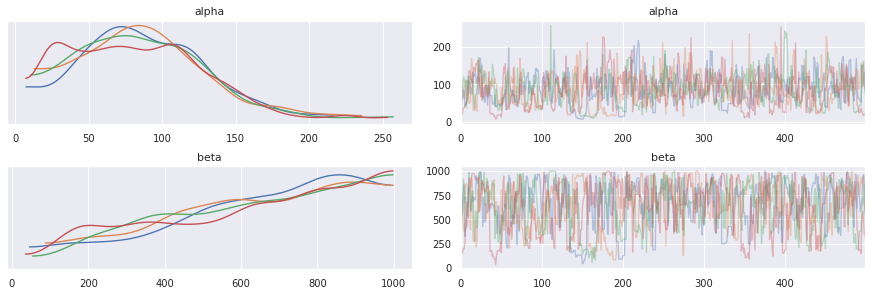

In [ ]:
# posterior analysis
with scoop_model:
    arviz.plot_trace(trace);

In [ ]:
# summary
with scoop_model:
  nuts_results = arviz.summary(trace)
  display(nuts_results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,85.386,42.788,12.470,158.455,2.205,1.560,377.0,377.0,312.0,168.0,1.01
beta,639.445,245.126,195.853,999.145,14.123,9.996,301.0,301.0,302.0,210.0,1.01


In [ ]:
alpha_est = nuts_results.loc['alpha', 'mean']
beta_est = nuts_results.loc['beta', 'mean']
t = np.linspace(2, 12, 12)

In [ ]:
def sgb_distribution(alpha, beta, t):
  prob = ((beta + t - 2) / (alpha + beta + t - 1))
  return prob

In [ ]:
sgb_retention = []
prob = alpha / (alpha + beta) # p1
surv = 1. - p1 # s1

for i in range(2, 12):
  prob, surv = sgb_distribution(alpha=alpha_est, beta=beta_est, t=i)
  sgb_retention.append((i, prob, surv))

sgb_retention

[(2, 0.880983314297681, -0.11901668570231905),
 (3, 0.8811470616965981, -0.11885293830340193),
 (4, 0.8813103591355687, -0.11868964086443134),
 (5, 0.8814732084667091, -0.11852679153329093),
 (6, 0.8816356115319849, -0.11836438846801511),
 (7, 0.88179757016328, -0.11820242983672002),
 (8, 0.8819590861824657, -0.11804091381753434),
 (9, 0.8821201614014691, -0.1178798385985309),
 (10, 0.8822807976223409, -0.1177192023776591),
 (11, 0.8824409966373221, -0.11755900336267788)]

### MAP results

In [ ]:
# MAP
map_estimate = pm.find_MAP(model=scoop_model)

map_estimate

logp = -49.404, ||grad|| = 0.00010093: 100%|██████████| 13/13 [00:00<00:00, 692.35it/s]  


{'alpha': array(0.15276744),
 'alpha_interval__': array(-8.78650647),
 'beta': array(0.69631911),
 'beta_interval__': array(-7.26902032)}

In [ ]:
with scoop_model:
  map_trace = pm.sampling.sample(draws=2000, init='map')
map_trace

Auto-assigning NUTS sampler...
Initializing NUTS using map...
logp = -49.404, ||grad|| = 0.00010093: 100%|██████████| 13/13 [00:00<00:00, 512.68it/s]  
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 2500/2500 [00:12<00:00, 205.32it/s]
The number of effective samples is smaller than 10% for some parameters.


<MultiTrace: 2 chains, 2000 iterations, 4 variables>

In [ ]:
map_trace

<MultiTrace: 2 chains, 2000 iterations, 4 variables>

In [ ]:
with scoop_model:
  map_trace = pm.sample_posterior_predictive(map_trace, samples=2000])

# show sampled parameter values
keys = ['alpha', 'beta']

nuts_samples = list(map(map_trace.get, keys))
nuts_samples

SyntaxError: ignored

In [ ]:
with scoop_model:
  pp_trace = pm.sample_posterior_predictive(map_trace, samples=2000, vars=[alpha, beta])

# show sampled parameter values
keys = ['alpha', 'beta']

nuts_samples = list(map(pp_trace.get, keys))
nuts_samples[0].mean()

In [ ]:
import numpy as np
import theano
from theano import tensor as T
w_values = np.random.randn(1152, 10).astype(theano.config.floatX)
input_values = np.random.randn(1152, 1).astype(theano.config.floatX)
w = theano.shared(w_values, 'w')
input = theano.shared(input_values, 'input')
result = T.dot(input.T, w)
print(result.eval())

In [ ]:
len(pp_trace[['alpha', 'beta']]), #pp_trace['alpha', 'beta'].agg('mean') #pp_trace['beta']

In [ ]:
pp_trace

In [ ]:
# calculation with alpha/beta based on MAP
map_alpha = map_estimate['alpha']
map_beta = map_estimate['beta']

print('map_alpha: ', map_alpha, ', map_beta: ', map_beta, '\n')


map_survival_rate = np.array(1)
map_churn_rate = np.array(0)

churn = map_alpha / (map_alpha + map_beta) # p1
surv = 1. - churn # s1
print(churn, surv, '\n')
print(type(surv))

for i in range(1, 12):
  churn = sgb_distribution(alpha=map_alpha, beta=map_beta, t=i) * churn
  surv = 1. - churn
  #print(churn, surv)
  map_survival_rate = np.append(map_survival_rate, surv)
  map_churn_rate = np.append(map_churn_rate, churn)
  
print(map_survival_rate)
print()
print(map_churn_rate)

map_alpha:  0.15276744123582148 , map_beta:  0.6963191065559186 

0.179919752153807 0.820080247846193 

<class 'numpy.float64'>
[1.         1.06434938 1.02423234 1.01442771 1.01010674 1.00770407
 1.00618572 1.0051446  1.00438903 1.00381727 1.00337049 1.00301236]

[ 0.         -0.06434938 -0.02423234 -0.01442771 -0.01010674 -0.00770407
 -0.00618572 -0.0051446  -0.00438903 -0.00381727 -0.00337049 -0.00301236]


In [ ]:
sgb_distribution(alpha=map_alpha, beta=map_beta, t=1)

-0.35765599423742933

In [ ]:
r_t = 1
map_survival_function = []

for i in range(0, 12):
  r_t = r_t * map_retention_rates[i]
  map_survival_function.append(round(r_t, 4))

map_survival_function

In [ ]:
# Forecasting Survival Rates
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(t, yhat_retention, ls='--', label='sample_survival_rate')
ax.plot(t, map_survival_function, ls='--', c='red', label='est_survival_rate (map)')

ax.plot(retention_matrix.columns, retention_matrix.loc['2019Q4'], c='darkgrey')
ax.plot(retention_matrix.columns, retention_matrix.loc['2020Q1'], c='silver')
ax.plot(retention_matrix.columns, retention_matrix.loc['2020Q2'], c='lightgrey')
ax.plot(retention_matrix.columns, retention_matrix.loc['2020Q3'], c='gainsboro')
ax.legend()

#ax.axis([0, 12, 0.4, 2])
ax.set_xticks([2, 4, 6, 8, 10, 12], minor=False)
ax.xaxis.grid(True, which='major')
ax.set_title('Scoop Survival Rate Forecast')
ax.set_xlabel('time scince first order (in quarters)')
ax.set_ylabel('survival in %')

## survival rate - chrun with weibull
https://catchjs.com/Blog/Churn

In [ ]:
import scipy as sp
import scipy.stats as stats

#duration of alive subscriptions
censored = np.array([133.65, 10.26, 0.24, 3.87, 23.84, 25.91, 41.83, 137.805, 0.985, 
                     100.39, 14.9, 18.72, 29.65, 13.11, 26.71, 22.64, 179.985, 9.6, 
                     37.61, 144.53, 18.855, 80.865, 88.56, 21.955, 73.945, 10.365])
#duration of completed subscriptions
uncensored = np.array([55.31, 47.03, 0.44, 190.41, 80.07, 0.77, 23.93, 151.72, 33.09, 
                       10.9, 140.41, 209.49, 21.38, 40.18, 99.26, 167.52, 16.75, 109.77, 
                       18.07, 90.23, 233.68, 27.09, 42.35, 109.06, 181.86, 24.5, 66.08, 19.25])

#Log likelihoods for censored data
def log_likelihood_weibull(args):
    shape, scale = args
    val = stats.weibull_min.logpdf(uncensored, shape, loc=0, scale=scale).sum() \
          + stats.weibull_min.logsf(censored, shape, loc=0, scale=scale).sum()
    return -val #sign is flipped so we can use a minimizer
    
def log_likelihood_lomax(args):
    shape, scale = args
    val = stats.lomax.logpdf(uncensored, shape, loc=0, scale=scale).sum() \
          + stats.lomax.logsf(censored, shape, loc=0, scale=scale).sum()
    return -val

In [ ]:
res_weibl = sp.optimize.minimize(log_likelihood_weibull, [1, 1], bounds=((0.001, 1000000), (0.001, 1000000)))
res_lomax = sp.optimize.minimize(log_likelihood_lomax,   [1, 1], bounds=((0.001, 1000000), (0.001, 1000000)))

## Computing the CLV

# Churn Prediction (logReg)
https://towardsdatascience.com/hands-on-predict-customer-churn-5c2a42806266

Questions:
- Which users users have a higher likelyhood to churn?
- Which features have the most impact on a customer leaving?

In [ ]:
df_members.head(2)

,index,member_ID,order_ID,name,collected?,order_requests,deposits,order_request_value,delivery_date,order_cumcount,delivery_date_month,cohort
0,0,1,1,XXX,True,"{'3': {'filled': '1.0', 'ordered': '1.0'}, '25...",NaN,89.49,2019-12-13,1,2019-12,2019-12
1,1,2,1,XXX,True,"{'39': {'filled': '1.0', 'ordered': '1.0'}, '6...",NaN,16.22,2019-12-13,1,2019-12,2019-12


## Feature selection (DataFrame members by ID)

In [ ]:
# create new DataFrame
members_by_ID = pd.DataFrame(df_members.groupby('member_ID').agg(
    cohort=('cohort', 'min'), # adds cohort tag
    first_ordered=('delivery_date', 'min'),
    last_ordered=('delivery_date', 'max'),
    lifetime_order_value=('order_request_value', 'sum'), # add lifetime_order_value
    lifetime_order_count=('order_ID', 'count') # add lifetime order count 
    ))

In [ ]:
# drop supercoop account with member_ID 46
members_by_ID.drop(46, inplace=True)

In [ ]:
# lifetime of a member
members_by_ID['lifetime_in_days'] = members_by_ID.last_ordered - members_by_ID.first_ordered
# lifetime in months
members_by_ID['lifetime_in_months'] = ((members_by_ID.last_ordered - members_by_ID.first_ordered) / np.timedelta64(1, 'M'))
# avg order count by month
members_by_ID['avg_order_count_mth'] = members_by_ID['lifetime_order_count'].divide(
    members_by_ID['lifetime_in_months']).replace(np.inf, 0)
# avg order value by month
members_by_ID['avg_order_value_mth'] = members_by_ID['lifetime_order_value'].divide(
    members_by_ID['lifetime_in_months']).replace(np.inf, 0)                                                                                                                   
# churned - not ordered in over 90 days
members_by_ID['churned_90d'] = (today - members_by_ID.last_ordered) > pd.Timedelta('90 days')

In [ ]:
# statistics of churned members 
members_by_ID[members_by_ID.churned_90d == True]

,cohort,first_ordered,last_ordered,lifetime_order_value,lifetime_order_count,lifetime_in_days,lifetime_in_months,avg_order_count_mth,avg_order_value_mth,churned_90d,max_days_between_orders
member_ID,,,,,,,,,,,
4,2019-12,2019-12-13,2019-12-13,15.36,2,0 days,0.000000,0.000000,0.000000,True,NaN
21,2019-12,2019-12-13,2019-12-13,3.63,1,0 days,0.000000,0.000000,0.000000,True,NaN
23,2020-02,2020-02-20,2020-05-15,29.73,7,85 days,2.792665,2.506566,10.645745,True,62.0
31,2019-12,2019-12-13,2019-12-13,186.85,1,0 days,0.000000,0.000000,0.000000,True,NaN
36,2020-02,2020-02-20,2020-02-20,66.64,1,0 days,0.000000,0.000000,0.000000,True,0.0
40,2019-12,2019-12-13,2019-12-13,24.68,2,0 days,0.000000,0.000000,0.000000,True,NaN
42,2020-03,2020-03-06,2020-05-22,162.08,23,77 days,2.529826,9.091534,64.067645,True,8.0
43,2020-02,2020-02-20,2020-05-15,37.95,6,85 days,2.792665,2.148485,13.589169,True,69.0
45,2020-03,2020-03-06,2020-05-29,755.52,36,84 days,2.759810,13.044375,273.757950,True,11.0


**What was the longest gap between orders of members?**
- between the first and second order was a 69d long gap, where no orders where placed. 
- bcause of this i started counting the period afterwards'

In [ ]:
# select columns 
longest_period = df_members.loc[:, ['member_ID', 'order_ID', 'delivery_date']]


longest_period = longest_period[longest_period.delivery_date >= pd.Timestamp('2020-02-20')]
longest_period['days_scince_last_order'] = longest_period.groupby(['member_ID'])['delivery_date'].diff()
longest_period['days_scince_last_order'] = pd.to_timedelta(longest_period['days_scince_last_order'], unit='D') # set datetime64[D]

In [ ]:
# add max_days_between_orders to members_by_ID DF
members_by_ID['max_days_between_orders'] = longest_period.groupby('member_ID')['days_scince_last_order'].max().astype('timedelta64[D]')
members_by_ID['max_days_between_orders'].fillna(0)

member_ID
1      21.0
2      27.0
3      21.0
4       0.0
6      28.0
7      21.0
9      55.0
10     34.0
11     90.0
12    119.0
13     28.0
17     15.0
19     50.0
20     21.0
21      0.0
22     21.0
23     62.0
30     20.0
31      0.0
33     15.0
34     56.0
35     35.0
36      0.0
38     43.0
39     22.0
40      0.0
41     22.0
42      8.0
43     69.0
44     41.0
45     11.0
47     22.0
48     14.0
49    154.0
50     15.0
51     28.0
52      7.0
54     14.0
55     14.0
56     14.0
57     29.0
58      7.0
60     14.0
61     12.0
62      7.0
63      6.0
Name: max_days_between_orders, dtype: float64

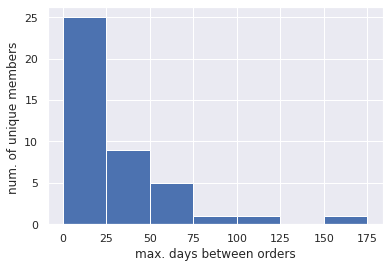

In [ ]:
# before plotting timedelta data -> .astype('timedelta64[D]')
# https://www.datasciencebytes.com/bytes/2015/05/16/pandas-timedelta-histograms-unit-conversion-and-overflow-danger/
members_by_ID['max_days_between_orders'].hist(bins=range(0, 200, 25))
plt.xlabel('max. days between orders')
plt.ylabel('num. of unique members ');

### scatter plots

In [ ]:
members_by_ID.head()

,cohort,first_ordered,last_ordered,lifetime_order_value,lifetime_order_count,lifetime_in_days,lifetime_in_months,avg_order_count_mth,avg_order_value_mth,churned_90d
member_ID,,,,,,,,,,
1,2019-12,2019-12-13,2020-11-11,3274.82,106,334 days,10.973531,9.659607,298.429003,False
2,2019-12,2019-12-13,2020-10-30,795.18,84,322 days,10.579273,7.940054,75.163957,False
3,2019-12,2019-12-13,2020-11-11,2138.84,87,334 days,10.973531,7.928168,194.908999,False
4,2019-12,2019-12-13,2019-12-13,15.36,2,0 days,0.000000,0.000000,0.000000,True
6,2020-03,2020-03-06,2020-11-11,2228.06,96,250 days,8.213721,11.687760,271.260735,False


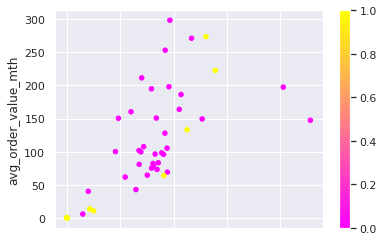

In [ ]:
# encode
churned_encoded = members_by_ID.churned_90d.map({True: 1, False: 0})
# avg order month vs. avg order count by month
members_by_ID.plot.scatter(x='avg_order_count_mth',
                           y='avg_order_value_mth',
                           c=churned_encoded,
                           cmap='spring'
                           )

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


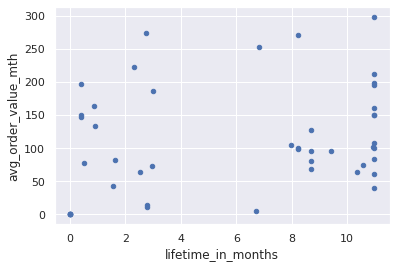

In [ ]:
members_by_ID.plot.scatter(x='lifetime_in_months',
                           y='avg_order_value_mth',
                           #c='cohort' # months since last order
                           )

### Logistic Regression model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

model = LogisticRegression()


## RFM churn prediction
* https://www.retentionscience.com/blog/rfm-king/

In [ ]:
# 

# Customer Segmentation
https://www.mktr.ai/applications-and-methods-in-data-science-customer-segmentation/

https://data-flair.training/blogs/r-data-science-project-customer-segmentation/